Data from https://data.cityofnewyork.us/api/odata/v4/hvrh-b6nb
    
Web URL : https://data.cityofnewyork.us/Transportation/2016-Green-Taxi-Trip-Data/hvrh-b6nb

## Sample Data

!head -1 NYC.csv > NYC_sample.csv
<br/>
!perl -ne 'print if (rand() < 0.07)' NYC.csv >> NYC_sample.csv

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from fastai.structured import *
from sklearn import metrics
from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sns.set(rc={'figure.figsize':(13,8)})


In [3]:
df = pd.read_csv("NYC_sample.csv")

In [4]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'PULocationID',
       'DOLocationID'],
      dtype='object')

In [5]:
len(df)

1148725

In [6]:
df.head().T

,0,1,2,3,4
VendorID,2,2,2,2,1
lpep_pickup_datetime,05/07/2016 02:25:05 AM,05/07/2016 02:21:26 AM,05/08/2016 12:54:22 AM,05/08/2016 12:51:46 AM,05/07/2016 04:19:06 PM
Lpep_dropoff_datetime,05/07/2016 02:38:19 AM,05/07/2016 02:43:46 AM,05/08/2016 01:10:20 AM,05/08/2016 01:04:24 AM,05/07/2016 04:24:20 PM
Store_and_fwd_flag,N,N,N,N,N
RateCodeID,1,1,1,1,1
Pickup_longitude,-73.9589,-73.9234,-73.956,-73.9156,-73.9391
Pickup_latitude,40.7168,40.7069,40.8047,40.7433,40.8054
Dropoff_longitude,-73.9324,-74.0163,-73.9173,-73.9135,-73.9538
Dropoff_latitude,40.7079,40.7112,40.8244,40.7657,40.8063
Passenger_count,6,1,1,1,1


### Handling Missing Values


In [7]:

na_counts = pd.DataFrame(df.isna().sum()/len(df)) 
na_counts.columns = ["null_row_pct"]
na_counts[na_counts.null_row_pct > 0].sort_values(by = "null_row_pct", ascending=False)


,null_row_pct
Ehail_fee,1.000000
PULocationID,0.550597
DOLocationID,0.550597
Pickup_longitude,0.449403
Pickup_latitude,0.449403
Dropoff_longitude,0.449403
Dropoff_latitude,0.449403
Trip_type,0.000030


In [8]:
na_counts.loc["Pickup_longitude"]["null_row_pct"] + na_counts.loc["PULocationID"]["null_row_pct"]

1.0

In [9]:
df = df[~(
    (df.Dropoff_latitude.isna()) & (df.DOLocationID.isna())
)]

In [10]:
len(df)

1148725

In [11]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime, errors = 'ignore')
df.Lpep_dropoff_datetime = pd.to_datetime(df.Lpep_dropoff_datetime, errors = 'ignore' )


In [12]:
pd.option_context("display.max_rows", 1000)
pd.option_context("display.max_columns", 1000)

In [13]:

df["trip_duration"] = np.log((df.Lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.seconds + 1)

drop_columns = [
    "Trip_type ", "Ehail_fee", "Extra", "Payment_type", "Total_amount", 
    "improvement_surcharge", "Tolls_amount", "Tip_amount", 
    "MTA_tax", "VendorID", "RateCodeID", "Store_and_fwd_flag", 
    "Fare_amount", "Lpep_dropoff_datetime", 'Trip_type ', 'Passenger_count'
]

df.drop(columns=drop_columns, inplace=True)

df.tail().T


,1148720,1148721,1148722,1148723,1148724
lpep_pickup_datetime,2016-05-07 16:24:05,2016-05-07 16:20:59,2016-05-07 16:20:50,2016-05-07 02:02:17,2016-05-07 02:24:26
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,NaN,NaN,NaN,NaN,NaN
DOLocationID,NaN,NaN,NaN,NaN,NaN
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796


In [14]:
add_datepart(df, 'lpep_pickup_datetime', time=True)
df.tail().T

,1148720,1148721,1148722,1148723,1148724
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,NaN,NaN,NaN,NaN,NaN
DOLocationID,NaN,NaN,NaN,NaN,NaN
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [35]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.76 # Earth radius in miles
    
    dLat, dLon, lat1, lat2 = np.radians(lat2 - lat1), np.radians(lon2 - lon1), \
    np.radians(lat1), np.radians(lat2)
    a =  np.sin(dLat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2) ** 2
    c = 2*np.arcsin(np.sqrt(a))
    
    return R * c

theta1 = np.radians(-28.904)
theta2 = np.radians(28.904)
R1 = np.array([[np.cos(theta1), np.sin(theta1)], [-np.sin(theta1), np.cos(theta1)]])
R2 = np.array([[np.cos(theta2), np.sin(theta2)], [-np.sin(theta2), np.cos(theta2)]])

def manhattan_dist(lat1, lon1, lat2, lon2):
    p = np.stack([lat1, lon1], axis = 1)
    d = np.stack([lat2, lon2], axis = 1)
    pT = R1 @ p.T  
    dT = R1 @ d.T  

    vT = np.stack((pT[0,:], dT[1,:]))
    v = R2 @ vT
    return (haversine(p.T[0], p.T[1], v[0], v[1]) + haversine(v[0], v[1], d.T[0], d.T[1]))

In [36]:
df["haversine_dist"] = haversine(df["Pickup_latitude"], df["Pickup_longitude"], \
                                     df["Dropoff_latitude"], df["Dropoff_longitude"])

df["manhattan_dist"] = manhattan_dist(df["Pickup_latitude"], df["Pickup_longitude"], \
                                          df["Dropoff_latitude"], df["Dropoff_longitude"])


In [37]:
train_cats(df)
df.tail().T

,1110646,1110647,1110648,1110649,1110650
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,41,61,41,256,255
DOLocationID,168,17,41,36,61
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [38]:
tdf, y, nas = proc_df(df, 'trip_duration')
nas

{'Pickup_longitude': -73.94575026755162,
 'Pickup_latitude': 40.74423471780132,
 'Dropoff_longitude': -73.94471740722656,
 'Dropoff_latitude': 40.74542236328125,
 'haversine_dist': 1.4892974700507058,
 'manhattan_dist': 1.9368229889000521}

In [39]:
df.tail().T

,1110646,1110647,1110648,1110649,1110650
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,41,61,41,256,255
DOLocationID,168,17,41,36,61
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [40]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000
n_trn = len(tdf)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(tdf, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1090651, 33), (1090651,), (20000, 33))

In [41]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

def print_score(m):
    res = f"""Train RMS : {rmse(m.predict(X_train), y_train)}, Valid RMSE : {rmse(m.predict(X_valid), y_valid)},
                Train R2 score : {m.score(X_train, y_train)}, Valid R2 score: {m.score(X_valid, y_valid)}"""
    if hasattr(m, 'oob_score_'): res += f"OOB Score : {m.oob_score_}"
    print(res)

In [179]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 43s, sys: 163 ms, total: 2min 43s
Wall time: 47.5 s
Train RMS : 0.2472352178974189, Valid RMSE : 0.5831388664229504,
                Train R2 score : 0.9372792009076454, Valid R2 score: 0.6508752199817067


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


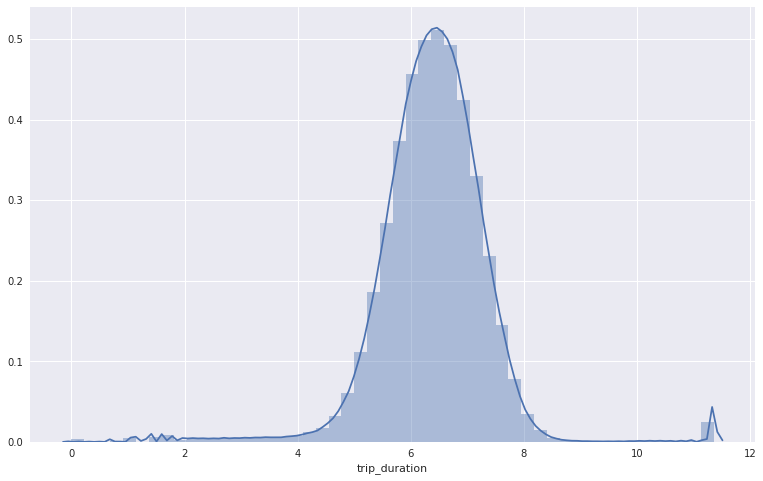

In [15]:
sns.distplot(df.trip_duration)

*Any trip duration greater than 6 hrs doesn't make sense and hence can be excluded*

In [16]:
df = df[( df.trip_duration > 5 ) & ( df.trip_duration < 9.5 )]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


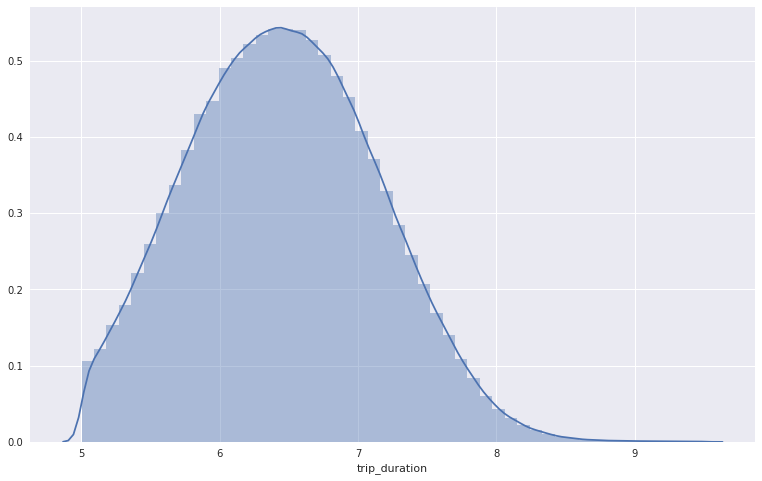

In [17]:
sns.distplot(df.trip_duration)

In [18]:
len(df)

1088688

In [184]:
tdf, y, nas = proc_df(df, 'trip_duration')

In [185]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000
n_trn = len(tdf)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(tdf, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((579113, 25), (579113,), (20000, 25))

In [186]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 39s, sys: 192 ms, total: 2min 39s
Wall time: 46.3 s
Train RMS : 0.11438209085016006, Valid RMSE : 0.273517313297294,
                Train R2 score : 0.9715939877473648, Valid R2 score: 0.8457534240263364


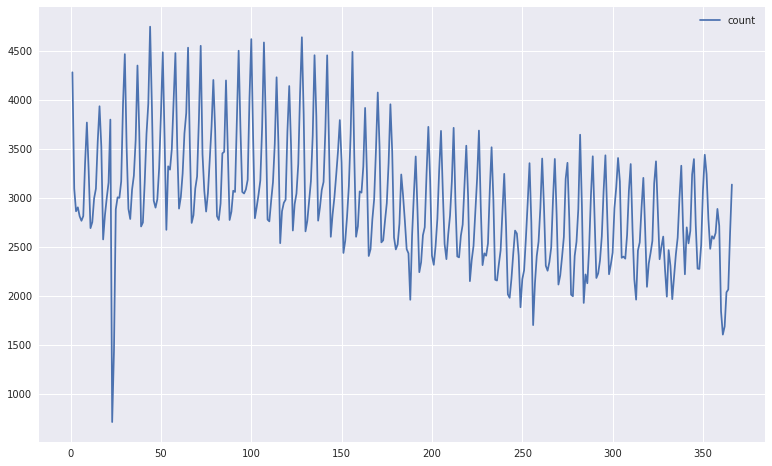

In [19]:
val_cnts = pd.DataFrame(df.lpep_pickup_datetimeDayofyear.value_counts(sort=False))
val_cnts.columns = ["count"]

val_cnts.plot()

# Adding Taxi Zones

In [20]:
taxi_zones = gpd.read_file("taxi_zones.shp")

taxi_zones.tail().T

,258,259,260,261,262
OBJECTID,259,260,261,262,263
Shape_Leng,0.12675,0.133514,0.0271205,0.0490636,0.0370166
Shape_Area,0.000394552,0.000422345,3.43423e-05,0.00012233,6.57698e-05
zone,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West
LocationID,259,260,261,262,263
borough,Bronx,Queens,Manhattan,Manhattan,Manhattan
geometry,"POLYGON ((1025414.781960189 270986.1393638253,...","POLYGON ((1011466.966050446 216463.0052037984,...","POLYGON ((980555.2043112218 196138.486258477, ...",(POLYGON ((999804.7945504487 224498.5270484537...,"POLYGON ((997493.3227153122 220912.3861623257,..."


In [21]:
taxi_zones.drop(columns = ["Shape_Leng", "Shape_Area", "OBJECTID"], inplace=True)

In [22]:
taxi_zones.tail()

,zone,LocationID,borough,geometry
258,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.781960189 270986.1393638253,..."
259,Woodside,260,Queens,"POLYGON ((1011466.966050446 216463.0052037984,..."
260,World Trade Center,261,Manhattan,"POLYGON ((980555.2043112218 196138.486258477, ..."
261,Yorkville East,262,Manhattan,(POLYGON ((999804.7945504487 224498.5270484537...
262,Yorkville West,263,Manhattan,"POLYGON ((997493.3227153122 220912.3861623257,..."


In [23]:
#Picking the Pickup and Dropoff coordinates for the first trip in our dataframe
vals = df[["Pickup_longitude","Pickup_latitude","Dropoff_longitude","Dropoff_latitude"]].iloc[0].values
vals

array([-73.95891,  40.71682, -73.93241,  40.70794])

(-74.28337047811291,
 -73.67222994897455,
 40.475144526078736,
 40.936503646094195)

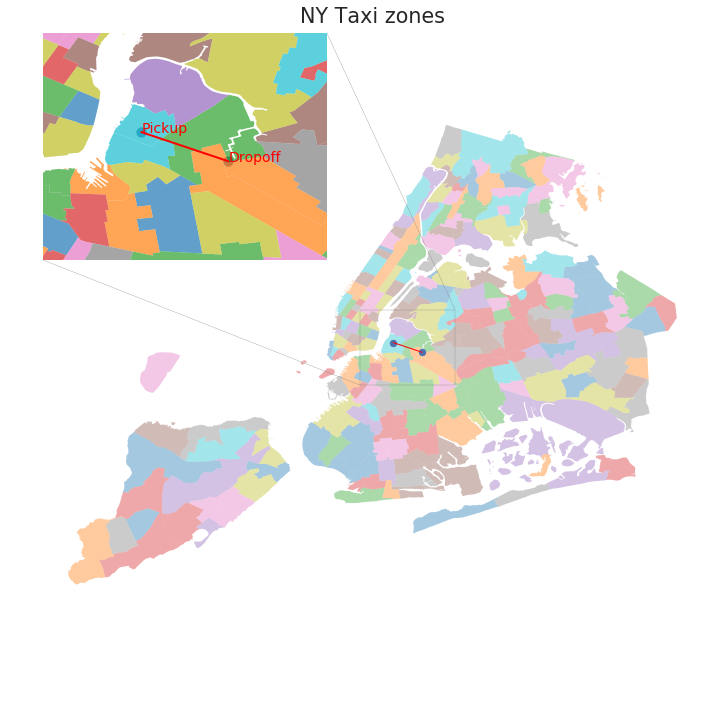

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

#Projecting Taxi Zones into WGS84 coordinate system
taxi_zones = taxi_zones.to_crs({'init': 'epsg:4326'})

f = ax
ax.set_xlim(min(src[0], target[0]) - 0.03, max(src[0], target[0]) + 0.03) # apply the x-limits
ax.set_ylim(min(src[1], target[1]) - 0.03, max(src[1], target[1]) + 0.03) # apply the y-limits

ax = taxi_zones.plot(column = "zone", figsize = (12, 12), alpha = 0.4)
ax.plot([vals[0], vals[2]], [vals[1], vals[3]], color = "red", linewidth=1) #Line
ax.scatter([vals[0], vals[2]], [vals[1], vals[3]], marker = 'o', s = 50) #Marker


axins = zoomed_inset_axes(ax, 3, loc=2)

axins.plot([vals[0], vals[2]], [vals[1], vals[3]], color = "red", linewidth=2)
axins.scatter([vals[0], vals[2]], [vals[1], vals[3]], marker = 'o', s = 100) #Markers
#Text at each marker
axins.text(vals[0], vals[1], s =  'Pickup', fontsize=14 ,color='r')
axins.text(vals[2], vals[3], s = 'Dropoff', fontsize=14, color='r')

axins.set_xlim(min(vals[0], vals[2]) - 0.03, max(vals[0], vals[2]) + 0.03) # apply the x-limits
axins.set_ylim(min(vals[1], vals[3]) - 0.03, max(vals[1], vals[3]) + 0.03) # apply the y-limits
axins.axis('off')

taxi_zones.plot(ax = axins, column = "zone", alpha = 0.7)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")


ax.axis('off')
ax.set_title("NY Taxi zones", fontsize='xx-large')
ax.axis('equal')

In [25]:
taxi_zones["X"] = taxi_zones.centroid.x
taxi_zones["Y"] = taxi_zones.centroid.y

In [26]:
taxi_zones.tail()

,zone,LocationID,borough,geometry,X,Y
258,Woodlawn/Wakefield,259,Bronx,POLYGON ((-73.85107116191899 40.91037152011096...,-73.852215,40.897932
259,Woodside,260,Queens,"POLYGON ((-73.9017537339999 40.76077547499995,...",-73.906306,40.744235
260,World Trade Center,261,Manhattan,"POLYGON ((-74.01332610899989 40.7050307879999,...",-74.013023,40.709139
261,Yorkville East,262,Manhattan,(POLYGON ((-73.94383256699986 40.7828590889999...,-73.946510,40.775932
262,Yorkville West,263,Manhattan,"POLYGON ((-73.95218621999996 40.7730198449999,...",-73.951010,40.778766


### Spatial Join and Dataframe Paralleization 

In [25]:
def parallelize_dataframe(func, iterator):
    with Pool(num_cores) as pool:
        results = pd.concat(pool.map(func, iterator))
        return results     
    

In [31]:
from shapely.geometry import Point

def assign_taxi_zones(df, lon_var, lat_var, locid_var):

    try:
        local_gdf = gpd.GeoDataFrame(
            crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(df[lon_var], df[lat_var])])

        local_gdf = gpd.sjoin(
            local_gdf, taxi_zones, how='left', op='within')

        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = np.nan
        return series

In [29]:
non_null_indices = df[~(df.DOLocationID.isna())].index
#df = df.loc[null_indices][["PULocationID", "DOLocationID"]]

df.loc[non_null_indices]["PULocationID"] = df.loc[non_null_indices]["PULocationID"].astype(int)
df.loc[non_null_indices]["DOLocationID"] = df.loc[non_null_indices]["DOLocationID"].astype(int)

In [30]:

df = pd.merge(df,  taxi_zones[["LocationID","X", "Y"]], how = "left", left_on = "PULocationID",  right_on = "LocationID")
df.Pickup_longitude.fillna(df.X, inplace=True)
df.Pickup_latitude.fillna(df.Y, inplace=True)


df.drop(columns=["LocationID", "X", "Y"], inplace=True)

df = pd.merge(df, taxi_zones[["LocationID","X", "Y"]], how = "left", left_on = "DOLocationID",  right_on = "LocationID")

df.Dropoff_longitude.fillna(df.X, inplace=True)
df.Dropoff_latitude.fillna(df.Y, inplace=True)

df.drop(columns=["LocationID", "X", "Y"], inplace=True)


df.tail().T

,1093828,1093829,1093830,1093831,1093832
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,NaN,NaN,NaN,NaN,NaN
DOLocationID,NaN,NaN,NaN,NaN,NaN
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [32]:
df['pickup_taxizone_id'] =  assign_taxi_zones(df, "Pickup_longitude","Pickup_latitude", "pickup_taxizone_id")
df['dropoff_taxizone_id'] = assign_taxi_zones(df, "Dropoff_longitude","Dropoff_latitude","dropoff_taxizone_id")
df.tail().T

,1093828,1093829,1093830,1093831,1093832
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,NaN,NaN,NaN,NaN,NaN
DOLocationID,NaN,NaN,NaN,NaN,NaN
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [33]:
df.PULocationID.fillna(df.pickup_taxizone_id, inplace=True)
df.DOLocationID.fillna(df.dropoff_taxizone_id, inplace=True)
df.drop(columns=["pickup_taxizone_id", "dropoff_taxizone_id"], inplace=True)


In [34]:
df = pd.merge(df, taxi_zones[["LocationID","borough"]], how = "left", left_on = "PULocationID",  right_on = "LocationID")

df.rename({"borough" : "pickup_borough"}, axis = 1, inplace=True)

df.drop(columns=["LocationID"], inplace = True)


df = pd.merge(df, taxi_zones[["LocationID","borough"]], how = "left",  left_on = "DOLocationID",  right_on = "LocationID")

df.rename({"borough" : "dropoff_borough"}, axis = 1, inplace=True)

df.drop(columns=["LocationID"], inplace = True)


df.tail().T

,1110646,1110647,1110648,1110649,1110650
Pickup_longitude,-73.9457,-73.9461,-73.9458,-73.963,-73.962
Pickup_latitude,40.8075,40.6802,40.8076,40.7119,40.716
Dropoff_longitude,-73.9253,-73.9492,-73.9572,-73.9174,-73.9569
Dropoff_latitude,40.818,40.6951,40.806,40.6987,40.6736
Trip_distance,1.6,1,0.9,3.37,3.31
PULocationID,41,61,41,256,255
DOLocationID,168,17,41,36,61
trip_duration,6.70073,5.78383,5.56068,6.96224,6.52796
lpep_pickup_datetimeYear,2016,2016,2016,2016,2016
lpep_pickup_datetimeMonth,5,5,5,5,5


In [66]:
len(df)

635226

In [201]:
train_cats(df)

In [202]:
tdf, y, nas = proc_df(df, 'trip_duration')

In [203]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000
n_trn = len(tdf)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(tdf, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((582718, 29), (582718,), (20000, 29))

In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMS : 0.09880475531046715, Valid RMSE : 0.2599229455143868,
                Train R2 score : 0.9786976405479708, Valid R2 score: 0.8602128925971101OOB Score : 0.8480746084914459


In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [206]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([5.7376 , 5.98027, 5.84946, 6.07379, 5.83006, 6.14319, 5.50377, 6.34913, 5.59438, 6.4391 , 5.73143,
        5.88606, 6.13323, 6.60402, 6.15025, 5.80589, 5.70721, 5.91291, 5.9523 , 5.86067, 6.10191, 5.9423 ,
        5.91118, 5.9069 , 5.64182, 5.87235, 5.52464, 6.2091 , 5.54754, 5.94511, 5.84109, 5.55949, 5.7278 ,
        5.51631, 5.92286, 6.10337, 5.47752, 5.85338, 5.65913, 5.80828]),
 5.882920632655627,
 5.356586274672012)

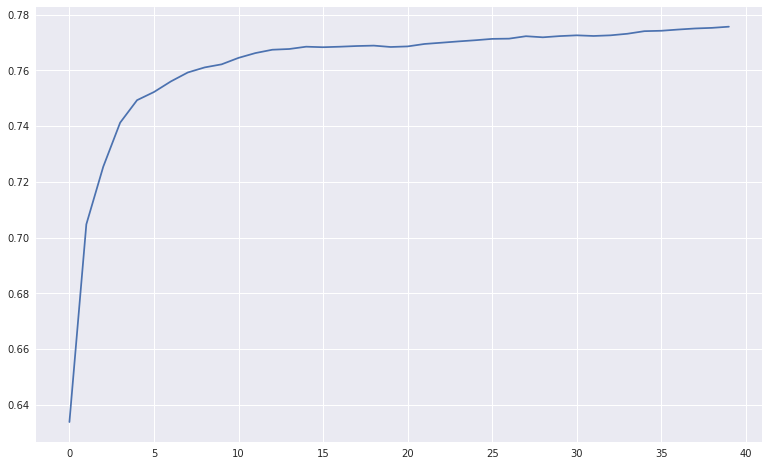

In [207]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

In [44]:
fi = rf_feat_importance(m, X_train); fi

,cols,imp
4,Trip_distance,0.539549
25,haversine_dist,0.185695
26,manhattan_dist,0.115578
19,lpep_pickup_datetimeHour,0.036124
2,Dropoff_longitude,0.019791
3,Dropoff_latitude,0.016847
1,Pickup_latitude,0.012517
0,Pickup_longitude,0.011310
11,lpep_pickup_datetimeDayofweek,0.009518
20,lpep_pickup_datetimeMinute,0.007038


In [50]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False, grid = False)

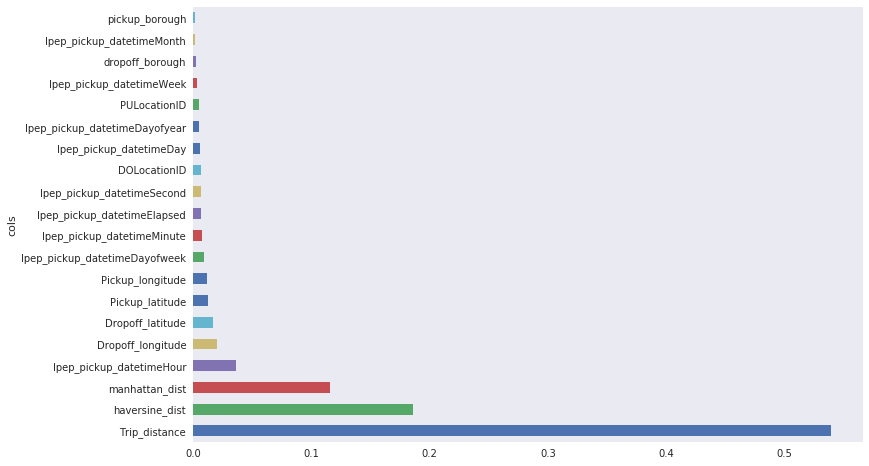

In [51]:
plot_fi(fi[:20]);

In [52]:
to_keep = fi[fi.imp>1e-3].cols; len(to_keep)

20

In [53]:
df_keep = tdf[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [213]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMS : 0.17039141160828364, Valid RMSE : 0.30508930906097315,
                Train R2 score : 0.9365196940800771, Valid R2 score: 0.7916392778194754OOB Score : 0.8579330841443042


In [54]:
from scipy.cluster import hierarchy as hc


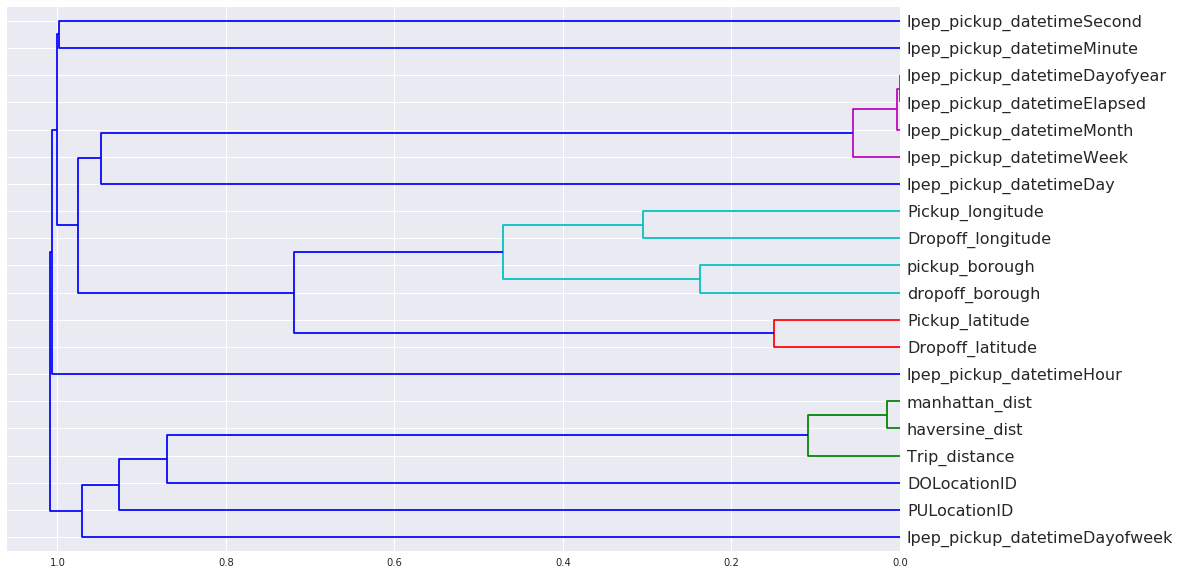

In [55]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [56]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, 
           max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [57]:
get_oob(df_keep)

0.8525535774012679

In [58]:
for c in ('haversine_dist', 'manhattan_dist' ,'lpep_pickup_datetimeDayofyear', 
  'lpep_pickup_datetimeElapsed',
  'lpep_pickup_datetimeMonth'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


haversine_dist 0.8527894584801484


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


manhattan_dist 0.853053682267824


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


lpep_pickup_datetimeDayofyear 0.8521976083174386
lpep_pickup_datetimeElapsed 0.8524607429681185
lpep_pickup_datetimeMonth 0.8523307565970708


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [220]:
to_drop = ['manhattan_dist', 'lpep_pickup_datetimeElapsed']
get_oob(df_keep.drop(to_drop, axis=1))

0.8564672801554589

In [226]:
X_train, X_valid = split_vals(df_keep, n_trn)
np.save('keep_cols.npy', np.array(df_keep.columns))
keep_cols = np.load('keep_cols.npy')
df_keep = tdf[keep_cols]

In [227]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMS : 0.14274155017874507, Valid RMSE : 0.3047424907726291,
                Train R2 score : 0.9554503365902474, Valid R2 score: 0.7921127276144841OOB Score : 0.8583902999840405
